In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping



Labeling, Agumenting Images, Train, Test split

In [ ]:
# Define the path to the main folder containing subfolders with images
main_folder = "/content/drive/MyDrive/Object_Images"

# Define label mapping
label_mapping = { "Car": 0, "Flower": 1, "Shoes": 2, "Sports_Ball" : 3, "Water_Bottle": 4}

# Define the ImageDataGenerator for data augmentation (on-the-fly) and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,  # Rotate images randomly up to 30 degrees
    width_shift_range=0.1,  # Shift images horizontally up to 10% of the widthq
    height_shift_range=0.1,  # Shift images vertically up to 10% of the height
    brightness_range=[0.8, 1.2],  # Adjust brightness randomly
    validation_split=0.3 #train and test split
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create training and validation data generators
train_generator = train_datagen.flow_from_directory(
    main_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    main_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

# Get the class indices from the generators
train_class_indices = train_generator.class_indices
validation_class_indices = validation_generator.class_indices

# Invert the dictionary to map indices to class names
train_inverse_indices = {v: k for k, v in train_class_indices.items()}
validation_inverse_indices = {v: k for k, v in validation_class_indices.items()}

# Count the number of images in each class in training set
print("Number of images in each class:")
for class_index in sorted(train_class_indices.values()):
    class_name = train_inverse_indices[class_index]
    class_dir = os.path.join(main_folder, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")



Found 177 images belonging to 5 classes.
Found 73 images belonging to 5 classes.
Number of images in each class:
Car: 45 images
Flower: 50 images
Shoes: 58 images
Sports_Ball: 51 images
Water_Bottle: 46 images


Plotting 16 random images

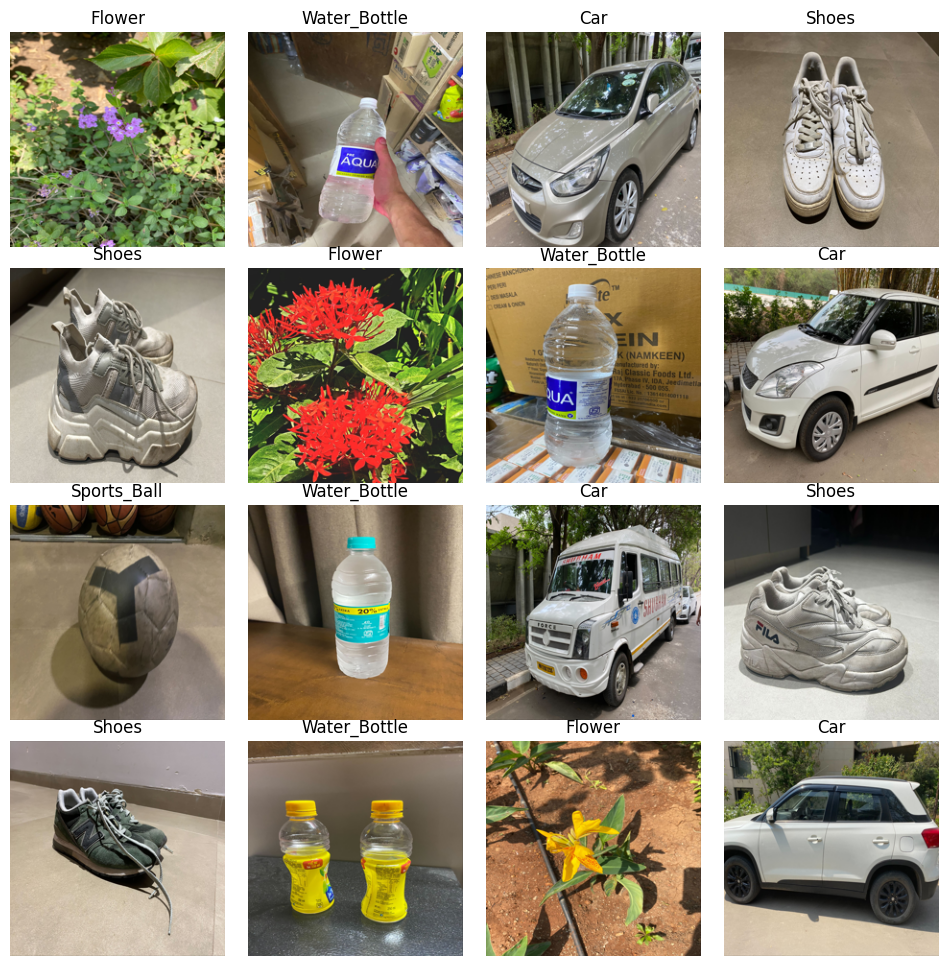

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from PIL import Image

# Get a list of filenames and labels from the training generator
filenames = train_generator.filenames
labels = train_generator.classes

# Select 16 random indices
random_indices = sample(range(len(filenames)), 16)

# Create a figure with 4x4 subplots
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.ravel()

# Load, resize, and plot the images with their labels
for i, idx in enumerate(random_indices):
    # Construct the full file path
    full_path = os.path.join(main_folder, filenames[idx])

    # Load the image
    img = Image.open(full_path)

    # Resize the image to a fixed size (e.g., 224x224)
    img = img.resize((224, 224))

    # Convert the image to a numpy array
    img = np.array(img)

    # Get the label
    label = list(label_mapping.keys())[list(label_mapping.values()).index(labels[idx])]

    # Plot the image and label
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### VGG 16 Architecture

In [ ]:
# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in vgg16_model.layers:
    layer.trainable = False

SEED = 44
tf.random.set_seed(SEED)

'''
#Iteration 1
# Define the model architecture
model = Sequential([
    vgg16_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])

#Iteration 2
model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),  # Add batch normalization layer
    Dropout(0.7),
    Dense(len(label_mapping), activation='softmax')
])

#Iteration 3
# Define the model architecture with L2 regularization and increased dropout
model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),  # Add L2 regularization
    BatchNormalization(),
    Dropout(0.7),  # Increase dropout rate
    Dense(len(label_mapping), activation='softmax')
])

#Iteration 4
model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),  # Increased the number of units in the first dense layer
    BatchNormalization(),
    Dropout(0.5),  # Decreased the dropout rate
    Dense(512, activation='relu'),  # Added an additional dense layer
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])

])
#Iteration 5
model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])
'''
#Iteration 6 - best model
model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(2048, activation='relu', kernel_regularizer=l2(0.001)), # increased units from 1024 to 2048
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])
'''
#Iteration 7
model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(2048, activation='relu', kernel_regularizer=l2(0.005)), # increased kernel_regularizer from 0.001 to 0.005
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])

#Iteration 8
model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(4048, activation='relu', kernel_regularizer=l2(0.005)), # increased kernel_regularizer from 0.001 to 0.005
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])

#Iteration 9
model = Sequential([
    vgg16_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(label_mapping), activation='softmax')
])

'''


58889256/58889256 [==============================] - 0s 0us/step


"\n#Iteration 7\nmodel = Sequential([\n    vgg16_model,\n    GlobalAveragePooling2D(),\n    Dropout(0.5),\n    Dense(2048, activation='relu', kernel_regularizer=l2(0.005)), # increased kernel_regularizer from 0.001 to 0.005\n    BatchNormalization(),\n    Dropout(0.5),\n    Dense(len(label_mapping), activation='softmax')\n])\n\n#Iteration 8\nmodel = Sequential([\n    vgg16_model,\n    GlobalAveragePooling2D(),\n    Dropout(0.5),\n    Dense(4048, activation='relu', kernel_regularizer=l2(0.005)), # increased kernel_regularizer from 0.001 to 0.005\n    BatchNormalization(),\n    Dropout(0.5),\n    Dense(len(label_mapping), activation='softmax')\n])\n\n#Iteration 9\nmodel = Sequential([\n    vgg16_model,\n    GlobalAveragePooling2D(),\n    Dropout(0.5),\n    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),\n    BatchNormalization(),\n    Dropout(0.5),\n    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),\n    BatchNormalization(),\n    Dropout(0.5),\n    Dense(len

Training VGG 16

In [ ]:
# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 15
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    epochs=epochs,
    verbose=1, # Set verbose=1 to print progress during training
    callbacks=[early_stopping]  # Add the early stopping callback
)

# Print training and validation accuracies after each epoch
for epoch in range(epochs):
    train_acc = history.history['accuracy'][epoch]
    val_acc = history.history['val_accuracy'][epoch]
    print(f'Epoch {epoch+1}/{epochs}: Training accuracy = {train_acc:.4f}, Validation accuracy = {val_acc:.4f}')

# Print the final training and validation accuracies
print(f'\nFinal training accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Final validation accuracy: {history.history["val_accuracy"][-1]:.4f}')

Epoch 1/15
5/5 [==============================] - 220s 44s/step - loss: 3.3668 - accuracy: 0.2069 - val_loss: 2.4212 - val_accuracy: 0.2188
Epoch 2/15
5/5 [==============================] - 140s 29s/step - loss: 2.8108 - accuracy: 0.2828 - val_loss: 2.3740 - val_accuracy: 0.2031
Epoch 3/15
5/5 [==============================] - 177s 39s/step - loss: 2.8454 - accuracy: 0.3034 - val_loss: 2.3268 - val_accuracy: 0.2969
Epoch 4/15
5/5 [==============================] - 181s 39s/step - loss: 2.4550 - accuracy: 0.4000 - val_loss: 2.2798 - val_accuracy: 0.4531
Epoch 5/15
5/5 [==============================] - 194s 42s/step - loss: 2.4038 - accuracy: 0.4563 - val_loss: 2.2454 - val_accuracy: 0.6406
Epoch 6/15
5/5 [==============================] - 178s 39s/step - loss: 2.1834 - accuracy: 0.5310 - val_loss: 2.1965 - val_accuracy: 0.7031
Epoch 7/15
5/5 [==============================] - 177s 38s/step - loss: 2.0575 - accuracy: 0.5310 - val_loss: 2.1450 - val_accuracy: 0.7500
Epoch 8/15
5/5 [====

Confusion Matrix

3/3 [==============================] - 50s 13s/step
Confusion Matrix:
[[3 3 3 2 2]
 [1 5 4 3 2]
 [4 1 2 7 3]
 [6 5 2 1 1]
 [2 2 6 1 2]]
Classification Report:
              precision    recall  f1-score   support

         Car       0.19      0.23      0.21        13
      Flower       0.31      0.33      0.32        15
       Shoes       0.12      0.12      0.12        17
 Sports_Ball       0.07      0.07      0.07        15
Water_Bottle       0.20      0.15      0.17        13

    accuracy                           0.18        73
   macro avg       0.18      0.18      0.18        73
weighted avg       0.18      0.18      0.18        73



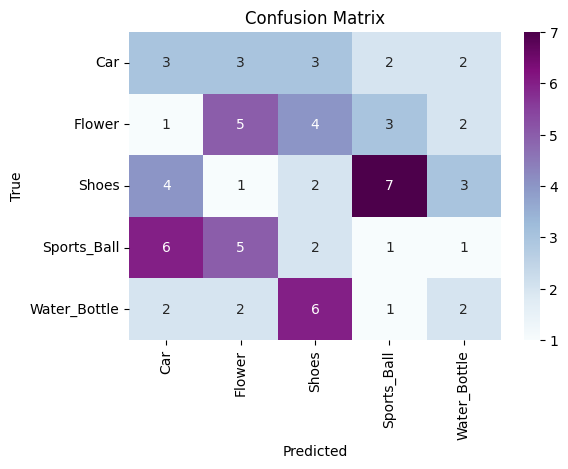

In [ ]:
# Get the true labels for the validation dataset
true_labels = validation_generator.classes

# Make predictions for the validation dataset
predictions = model.predict(validation_generator)

# Decode predictions to get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=label_mapping.keys())

# Print classification report
print("Classification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Save model using joblib

In [ ]:
import joblib
# Save the model
joblib.dump(model, 'Image_Object_Classifier.joblib')

['Image_Object_Classifier.joblib']

Load model

In [ ]:
loaded_model = joblib.load('Image_Object_Classifier.joblib')

Input Image

1/1 [==============================] - 1s 1s/step
Predicted Class: Water_Bottle
Confidence: 0.29833418


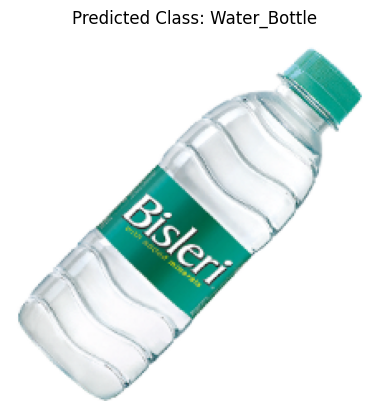

In [ ]:
# Load and preprocess the input image
input_image_path = "/content/water bottle.png"
img = image.load_img(input_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = img_array / 255.0  # Rescale to [0,1]

# Make predictions
predictions = model.predict(preprocessed_img)

# Decode predictions
predicted_class = np.argmax(predictions)
predicted_label = list(label_mapping.keys())[predicted_class]
confidence = predictions[0][predicted_class]

# Print predicted class and confidence
print("Predicted Class:", predicted_label)
print("Confidence:", confidence)

# Display the input image
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_label}')
plt.show()

### ResNet 50 Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the pre-trained ResNet50 model
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in resnet50_model.layers:
    layer.trainable = False

SEED = 42
tf.random.set_seed(SEED)

# Define the ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create training and validation data generators
train_generator = train_datagen.flow_from_directory(
    main_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    main_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

'''
# Define the model architecture
#Iteration 1
model_2 = tf.keras.Sequential([
    resnet50_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_mapping), activation='softmax')
])

'''
#Iteration 2
model_2 = tf.keras.Sequential([
    resnet50_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(label_mapping), activation='softmax')
])
'''


94765736/94765736 [==============================] - 0s 0us/step
Found 201 images belonging to 5 classes.
Found 49 images belonging to 5 classes.


"\n#Iteration 2\nmodel_2 = tf.keras.Sequential([\n    resnet50_model,\n    tf.keras.layers.GlobalAveragePooling2D(),\n    tf.keras.layers.Dense(1024, activation='relu'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(512, activation='relu'),\n    tf.keras.layers.Dropout(0.3),\n    tf.keras.layers.Dense(len(label_mapping), activation='softmax')\n])\n"

Training ResNet 50

In [ ]:
# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
history_ = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    verbose=1)  # Set verbose=1 to print progress during training

# Print training and validation accuracies after each epoch
for epoch in range(epochs):
    train_acc = history_.history['accuracy'][epoch]
    val_acc = history_.history['val_accuracy'][epoch]
    print(f'Epoch {epoch+1}/{epochs}: Training accuracy = {train_acc:.4f}, Validation accuracy = {val_acc:.4f}')

# Print the final training and validation accuracies
print(f'\nFinal training accuracy: {history_.history["accuracy"][-1]:.4f}')
print(f'Final validation accuracy: {history_.history["val_accuracy"][-1]:.4f}')

Epoch 1/20
6/6 [==============================] - 120s 18s/step - loss: 17.7667 - accuracy: 0.2485 - val_loss: 14.4667 - val_accuracy: 0.2812
Epoch 2/20
6/6 [==============================] - 53s 8s/step - loss: 15.6014 - accuracy: 0.2840 - val_loss: 2.4277 - val_accuracy: 0.3125
Epoch 3/20
6/6 [==============================] - 53s 8s/step - loss: 9.4045 - accuracy: 0.3254 - val_loss: 6.6313 - val_accuracy: 0.2500
Epoch 4/20
6/6 [==============================] - 51s 8s/step - loss: 7.8238 - accuracy: 0.3314 - val_loss: 2.5167 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 56s 9s/step - loss: 3.3102 - accuracy: 0.3906 - val_loss: 1.1163 - val_accuracy: 0.4375
Epoch 6/20
6/6 [==============================] - 55s 9s/step - loss: 1.3130 - accuracy: 0.5325 - val_loss: 1.5269 - val_accuracy: 0.4062
Epoch 7/20
6/6 [==============================] - 56s 9s/step - loss: 1.1997 - accuracy: 0.5976 - val_loss: 1.1661 - val_accuracy: 0.4688
Epoch 8/20
6/6 [=============

Confusion Matrix

2/2 [==============================] - 13s 3s/step
Confusion Matrix:
[[0 1 5 3 0]
 [3 0 3 4 0]
 [0 1 8 1 1]
 [1 0 3 6 0]
 [1 0 4 4 0]]
Classification Report:
              precision    recall  f1-score   support

         Car       0.00      0.00      0.00         9
      Flower       0.00      0.00      0.00        10
       Shoes       0.35      0.73      0.47        11
 Sports_Ball       0.33      0.60      0.43        10
Water_Bottle       0.00      0.00      0.00         9

    accuracy                           0.29        49
   macro avg       0.14      0.27      0.18        49
weighted avg       0.15      0.29      0.19        49



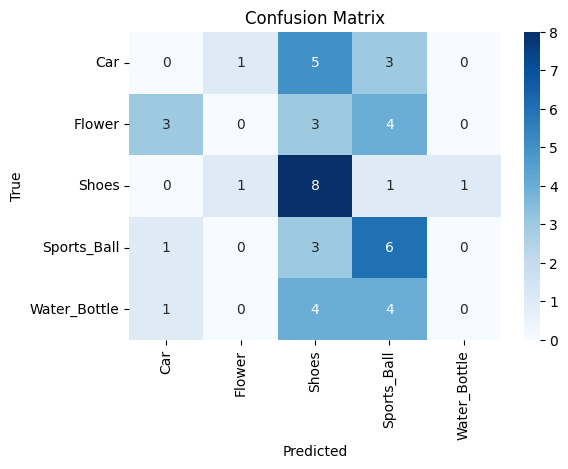

In [ ]:
# Get the true labels for the validation dataset
true_labels = validation_generator.classes

# Make predictions for the validation dataset
predictions = model_2.predict(validation_generator)

# Decode predictions to get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=label_mapping.keys())

# Print classification report
print("Classification Report:")
print(report)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Input Image

1/1 [==============================] - 1s 1s/step
Predicted Class: Shoes
Confidence: 0.4049606


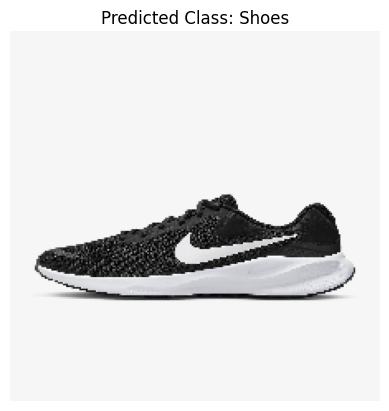

In [ ]:
# Load and preprocess the input image
input_image_path = "/content/shoe.png"
img = image.load_img(input_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = img_array / 255.0  # Rescale to [0,1]

# Make predictions
predictions = model_2.predict(preprocessed_img)

# Decode predictions
predicted_class = np.argmax(predictions)
predicted_label = list(label_mapping.keys())[predicted_class]
confidence = predictions[0][predicted_class]

# Print predicted class and confidence
print("Predicted Class:", predicted_label)
print("Confidence:", confidence)

# Display the input image
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_label}')
plt.show()
